<a href="https://colab.research.google.com/github/samarranjit/Yield_Prediction/blob/main/ExploringPossibleModelsForYieldPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Installing and Importing the required libraries

In [ ]:
!pip install rasterio
!pip install whitebox
!pip install tqdm
!pip install tqdm_joblib
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 54.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.0/74.0 kB 6.4 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import rasterio
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import rasterio.features
import rasterio.warp
import whitebox
from rasterio.enums import Resampling
from rasterio.io import MemoryFile
from rasterio.warp import reproject, calculate_default_transform
import matplotlib.pyplot as plt
import ee
import geemap
from shapely.geometry import Point
import xgboost as xgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from scipy.stats import uniform, randint, loguniform
from tqdm import tqdm
from tqdm_joblib import tqdm_joblib
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
from xgboost import XGBRegressor

/usr/local/lib/python3.12/dist-packages/tqdm_joblib/__init__.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


### Importing yield data with input variables

In [ ]:
soy_fn = r"/content/drive/MyDrive/Colab Notebooks/Data For Yield Prediction/Data/df_soybeans_absolute_all_years_with_divided_precipitation.parquet"
corn_fn = r"/content/drive/MyDrive/Colab Notebooks/Data For Yield Prediction/Data/df_corn_absolute_all_years_with_divided_precipitation.parquet"
wheat_fn = r"/content/drive/MyDrive/Colab Notebooks/Data For Yield Prediction/Data/df_wheat_absolute_all_years_with_divided_precipitation2.parquet"

df_soybeans = pd.read_parquet(soy_fn)
df_corn = pd.read_parquet(corn_fn)
df_wheat = pd.read_parquet(wheat_fn)

print(df_soybeans.describe())
print(df_corn.describe())
print(df_wheat.describe())

                   x             y          yield           year  \
count  611315.000000  6.113150e+05  611315.000000  611315.000000   
mean   337339.638666  4.321327e+06      46.694985    2019.207328   
std      2571.816114  8.672437e+02      16.998010       2.978032   
min    330893.532259  4.318616e+06       4.139045    2014.000000   
25%    336099.599602  4.320616e+06      34.509420    2017.000000   
50%    336840.073515  4.321341e+06      46.845428    2019.000000   
75%    339214.129061  4.321947e+06      59.010979    2022.000000   
max    342733.656286  4.323242e+06     116.790192    2024.000000   

           ndvi_mean       ndvi_max     ndvi_range   lst_median_k  \
count  611315.000000  611315.000000  611315.000000  611315.000000   
mean        0.546852       0.867373       0.598420     301.906139   
std         0.084386       0.079921       0.153782       3.212771   
min         0.253719       0.324230       0.000000     289.562653   
25%         0.493608       0.840899       

### Let's remove abnormal extreme values in the input variables




GI is just a ratio so it could have a lot of extreme values

In [ ]:
df_soybeans = df_soybeans[df_soybeans['gi_max'] < df_soybeans['gi_max'].quantile(0.98)]
df_wheat = df_wheat[df_wheat['gi_max'] < df_wheat['gi_max'].quantile(0.98)]
df_corn = df_corn[df_corn['gi_max'] < df_corn['gi_max'].quantile(0.98)]

### Let's remove the extreme values


In [ ]:
df_wheat = df_wheat[(df_wheat["yield"] < df_wheat["yield"].quantile(0.98)) & (df_wheat["yield"] > df_wheat["yield"].quantile(0.02))]
df_soybeans = df_soybeans[(df_soybeans["yield"] < df_soybeans["yield"].quantile(0.98)) & (df_soybeans["yield"] > df_soybeans["yield"].quantile(0.02))]
df_corn = df_corn[(df_corn["yield"] < df_corn["yield"].quantile(0.98)) & (df_corn["yield"] > df_corn["yield"].quantile(0.02))]

### Getting the interactin variables for the topographic variables

In [ ]:
df = df_wheat.copy()
df['elevation_squared'] = df['elevation'] ** 2
df['slope_squared'] = df['slope'] ** 2
df['elev_slope'] = df['elevation'] * df['slope']
df['elev_aspect'] = df['elevation'] * df['aspect']
df['slope_aspect'] = df['slope'] * df['aspect']


df['ndvi_pr'] = df['ndvi_mean'] * df['pr_season_mm']

df['aspect_southness'] = 1 - np.abs((df['aspect'] - 180) / 180)
df.info()

df_wheat = df.copy()

<class 'pandas.core.frame.DataFrame'>
Index: 173073 entries, 262 to 21167
Data columns (total 64 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   x                       173073 non-null  float64
 1   y                       173073 non-null  float64
 2   yield                   173073 non-null  float64
 3   field                   173073 non-null  object 
 4   year                    173073 non-null  int64  
 5   elevation               173073 non-null  float32
 6   slope                   173073 non-null  float32
 7   aspect                  173073 non-null  float32
 8   ndvi_mean               173073 non-null  float64
 9   ndvi_max                173073 non-null  float64
 10  ndvi_range              173073 non-null  float64
 11  lst_median_k            173073 non-null  float64
 12  lst_range_k             173073 non-null  float64
 13  lst_max_k               173073 non-null  float64
 14  pr_season_mm            

In [ ]:
df_soybeans.keys()

Index(['x', 'y', 'yield', 'field', 'year', 'ndvi_mean', 'ndvi_max',
       'ndvi_range', 'lst_median_k', 'lst_range_k', 'lst_max_k',
       'pr_season_mm', 'pr_mean_mm_day', 'pr_max_mm_day', 'pr_range_mm_day',
       'aridity', 'theta_s', 'clay_pct', 'ksat', 'evi_mean', 'evi_max',
       'evi_range', 'gi_mean', 'gi_max', 'gi_range', 'ndwi_mean', 'ndwi_max',
       'ndwi_range', 'tr_swir1_mean', 'tr_swir1_max', 'tr_swir1_range',
       'tr_swir2_mean', 'tr_swir2_max', 'tr_swir2_range', 'elevation', 'slope',
       'aspect', 'elevation_squared', 'slope_squared', 'elev_slope',
       'elev_aspect', 'slope_aspect', 'ndvi_pr', 'aspect_southness',
       'fall_aridity', 'fall_pr_max_mm_day', 'fall_pr_mean_mm_day',
       'fall_pr_range_mm_day', 'fall_pr_season_mm', 'spring_aridity',
       'spring_pr_max_mm_day', 'spring_pr_mean_mm_day',
       'spring_pr_range_mm_day', 'spring_pr_season_mm', 'summer_aridity',
       'summer_pr_max_mm_day', 'summer_pr_mean_mm_day',
       'summer_pr_range_mm

In [ ]:
df_corn.keys()

Index(['x', 'y', 'yield', 'field', 'year', 'elevation', 'slope', 'aspect',
       'ndvi_mean', 'ndvi_max', 'ndvi_range', 'lst_median_k', 'lst_range_k',
       'lst_max_k', 'pr_season_mm', 'pr_mean_mm_day', 'pr_max_mm_day',
       'pr_range_mm_day', 'aridity', 'theta_s', 'clay_pct', 'ksat', 'evi_mean',
       'evi_max', 'evi_range', 'gi_mean', 'gi_max', 'gi_range', 'ndwi_mean',
       'ndwi_max', 'ndwi_range', 'tr_swir1_mean', 'tr_swir1_max',
       'tr_swir1_range', 'tr_swir2_mean', 'tr_swir2_max', 'tr_swir2_range',
       'elevation_squared', 'slope_squared', 'elev_slope', 'elev_aspect',
       'slope_aspect', 'ndvi_pr', 'aspect_southness', 'fall_aridity',
       'fall_pr_max_mm_day', 'fall_pr_mean_mm_day', 'fall_pr_range_mm_day',
       'fall_pr_season_mm', 'spring_aridity', 'spring_pr_max_mm_day',
       'spring_pr_mean_mm_day', 'spring_pr_range_mm_day',
       'spring_pr_season_mm', 'summer_aridity', 'summer_pr_max_mm_day',
       'summer_pr_mean_mm_day', 'summer_pr_range_mm_day',


In [ ]:
df_wheat.keys()

Index(['x', 'y', 'yield', 'field', 'year', 'elevation', 'slope', 'aspect',
       'ndvi_mean', 'ndvi_max', 'ndvi_range', 'lst_median_k', 'lst_range_k',
       'lst_max_k', 'pr_season_mm', 'pr_mean_mm_day', 'pr_max_mm_day',
       'pr_range_mm_day', 'aridity', 'theta_s', 'clay_pct', 'ksat', 'evi_mean',
       'evi_max', 'evi_range', 'gi_mean', 'gi_max', 'gi_range', 'ndwi_mean',
       'ndwi_max', 'ndwi_range', 'tr_swir1_mean', 'tr_swir1_max',
       'tr_swir1_range', 'tr_swir2_mean', 'tr_swir2_max', 'tr_swir2_range',
       'fall_aridity', 'fall_pr_max_mm_day', 'fall_pr_mean_mm_day',
       'fall_pr_range_mm_day', 'fall_pr_season_mm', 'spring_aridity',
       'spring_pr_max_mm_day', 'spring_pr_mean_mm_day',
       'spring_pr_range_mm_day', 'spring_pr_season_mm', 'summer_aridity',
       'summer_pr_max_mm_day', 'summer_pr_mean_mm_day',
       'summer_pr_range_mm_day', 'summer_pr_season_mm', 'winter_aridity',
       'winter_pr_max_mm_day', 'winter_pr_mean_mm_day',
       'winter_pr_range_

### Normal Scaling the Variables


In [ ]:
from sklearn.preprocessing import StandardScaler

# scaling the variables that need scaling

need_std = [
    "elevation", "slope", "aspect",
    "slope_squared", "elevation_squared",
    "elev_slope", "elev_aspect", "slope_aspect",
    "lst_median_k", "lst_range_k", "lst_max_k",
    "pr_season_mm", "pr_mean_mm_day", "pr_max_mm_day", "pr_range_mm_day",
    "clay_pct", "ksat", "ndvi_pr", "gi_mean", "gi_max", "gi_range",
     'fall_aridity', 'fall_pr_max_mm_day', 'fall_pr_mean_mm_day',
       'fall_pr_range_mm_day', 'fall_pr_season_mm', 'spring_aridity',
       'spring_pr_max_mm_day', 'spring_pr_mean_mm_day',
       'spring_pr_range_mm_day', 'spring_pr_season_mm', 'summer_aridity',
       'summer_pr_max_mm_day', 'summer_pr_mean_mm_day',
       'summer_pr_range_mm_day', 'summer_pr_season_mm', 'winter_aridity',
       'winter_pr_max_mm_day', 'winter_pr_mean_mm_day',
       'winter_pr_range_mm_day', 'winter_pr_season_mm'

]

# Copy full dataset
df_wheat_scaled = df_wheat.copy()

# Fit scaler on all years (2014–2024)
scaler = StandardScaler()
df_wheat_scaled[need_std] = scaler.fit_transform(df_wheat_scaled[need_std])

need_std = [
    "elevation", "slope", "aspect",
    "slope_squared", "elevation_squared",
    "elev_slope", "elev_aspect", "slope_aspect",
    "lst_median_k", "lst_range_k", "lst_max_k",
    "pr_season_mm", "pr_mean_mm_day", "pr_max_mm_day", "pr_range_mm_day",
    "clay_pct", "ksat", "ndvi_pr", "gi_mean", "gi_max", "gi_range",
     'fall_aridity', 'fall_pr_max_mm_day', 'fall_pr_mean_mm_day',
       'fall_pr_range_mm_day', 'fall_pr_season_mm', 'spring_aridity',
       'spring_pr_max_mm_day', 'spring_pr_mean_mm_day',
       'spring_pr_range_mm_day', 'spring_pr_season_mm', 'summer_aridity',
       'summer_pr_max_mm_day', 'summer_pr_mean_mm_day',
       'summer_pr_range_mm_day', 'summer_pr_season_mm'

]

# Copy full dataset
df_soybeans_scaled = df_soybeans.copy()

# Fit scaler on all years (2014–2024)
scaler = StandardScaler()
df_soybeans_scaled[need_std] = scaler.fit_transform(df_soybeans_scaled[need_std])



# Copy full dataset
df_corn_scaled = df_corn.copy()

# Fit scaler on all years (2014–2024)
scaler = StandardScaler()
df_corn_scaled[need_std] = scaler.fit_transform(df_corn_scaled[need_std])


In [ ]:
df_soybeans_scaled.info()

<class 'pandas.core.frame.DataFrame'>
Index: 575115 entries, 0 to 55520
Data columns (total 59 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   x                       575115 non-null  float64
 1   y                       575115 non-null  float64
 2   yield                   575115 non-null  float64
 3   field                   575115 non-null  object 
 4   year                    575115 non-null  int64  
 5   ndvi_mean               575115 non-null  float64
 6   ndvi_max                575115 non-null  float64
 7   ndvi_range              575115 non-null  float64
 8   lst_median_k            575115 non-null  float64
 9   lst_range_k             575115 non-null  float64
 10  lst_max_k               575115 non-null  float64
 11  pr_season_mm            575115 non-null  float64
 12  pr_mean_mm_day          575115 non-null  float64
 13  pr_max_mm_day           575115 non-null  float64
 14  pr_range_mm_day         57

In [ ]:
df_wheat_scaled.info()

<class 'pandas.core.frame.DataFrame'>
Index: 173073 entries, 262 to 21167
Data columns (total 64 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   x                       173073 non-null  float64
 1   y                       173073 non-null  float64
 2   yield                   173073 non-null  float64
 3   field                   173073 non-null  object 
 4   year                    173073 non-null  int64  
 5   elevation               173073 non-null  float64
 6   slope                   173073 non-null  float64
 7   aspect                  173073 non-null  float64
 8   ndvi_mean               173073 non-null  float64
 9   ndvi_max                173073 non-null  float64
 10  ndvi_range              173073 non-null  float64
 11  lst_median_k            173073 non-null  float64
 12  lst_range_k             173073 non-null  float64
 13  lst_max_k               173073 non-null  float64
 14  pr_season_mm            

In [ ]:
df_corn_scaled.info()

<class 'pandas.core.frame.DataFrame'>
Index: 340116 entries, 0 to 21160
Data columns (total 59 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   x                       340116 non-null  float64
 1   y                       340116 non-null  float64
 2   yield                   340116 non-null  float64
 3   field                   340116 non-null  object 
 4   year                    340116 non-null  int64  
 5   elevation               340116 non-null  float64
 6   slope                   340116 non-null  float64
 7   aspect                  340116 non-null  float64
 8   ndvi_mean               340116 non-null  float64
 9   ndvi_max                340116 non-null  float64
 10  ndvi_range              340116 non-null  float64
 11  lst_median_k            340116 non-null  float64
 12  lst_range_k             340116 non-null  float64
 13  lst_max_k               340116 non-null  float64
 14  pr_season_mm            34

In [ ]:
df_soybeans_scaled['field'].nunique()

108

In [ ]:
# keep these to avoid hidden BLAS thread storms
import os, time
os.environ.setdefault("OMP_NUM_THREADS", "1")
os.environ.setdefault("MKL_NUM_THREADS", "1")

import numpy as np
import pandas as pd
from scipy.stats import pearsonr
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GroupKFold, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.impute import SimpleImputer

SEED = 42
print("[STEP] Starting script")

# ==== Data & grouping intent ====
print("[STEP] Copying source dataframe -> df_all")
df_all = df_soybeans_scaled.copy()

target_col = "yield"
year_col   = "year"
group_col  = "field_year"   # or "field_id"

# Build field×year if needed
if group_col == "field_year":
    print("[INFO] Building 'field_year' column")
    df_all["field_year"] = df_all["field"].astype(str) + "_" + df_all["year"].astype(str)

# ==== Feature set (MANUALLY SELECTED) ====
selected_features = [
    "ndvi_max", "gi_max", "ndwi_max", "evi_max", "pr_season_mm", "lst_median_k"
]
id_like = {"field_id", "field", "field_name", "field_year"}
exclude = {target_col, year_col, group_col} | id_like
available_numeric = [c for c in df_all.columns if np.issubdtype(df_all[c].dtype, np.number)]
feature_cols = [c for c in selected_features if c in available_numeric and c not in exclude]
missing = sorted(set(selected_features) - set(feature_cols))
if missing:
    print(f"[WARN] Skipped missing/non-numeric/excluded features: {missing}")

print(f"[DATA] Total rows: {len(df_all):,}")
print(f"[DATA] Feature count: {len(feature_cols)}")
print(f"[DATA] Sample features: {feature_cols[:6]} ...")

# ==== Split by year ====
TEST_YEAR = 2023
print(f"[STEP] Splitting train/test with TEST_YEAR={TEST_YEAR}")
train_df = df_all[df_all[year_col] != TEST_YEAR].reset_index(drop=True)
test_df  = df_all[df_all[year_col] == TEST_YEAR].reset_index(drop=True)
print(f"[DATA] Train rows: {len(train_df):,} | Test rows: {len(test_df):,}")

# Guard: enough groups for CV
n_groups = train_df[group_col].nunique()
print(f"[CHECK] Unique groups in train ({group_col}): {n_groups}")
assert n_groups >= 3, f"Only {n_groups} groups in train; reduce n_splits or change grouping."

X_train = train_df[feature_cols]
y_train = train_df[target_col].values
groups  = train_df[group_col].values

X_test  = test_df[feature_cols]
y_test  = test_df[target_col].values

# ==== Impute (RF cannot handle NaN) ====
print("[STEP] Imputing missing values with SimpleImputer(median)")
imp = SimpleImputer(strategy="median")
X_train_imp = pd.DataFrame(imp.fit_transform(X_train), columns=feature_cols, index=X_train.index)
X_test_imp  = pd.DataFrame(imp.transform(X_test),  columns=feature_cols, index=X_test.index)
print("[DONE] Imputation complete")

# ==== Group-aware CV (smaller for speed) ====
n_splits = 5
gkf = GroupKFold(n_splits=n_splits)
print(f"[STEP] GroupKFold with n_splits={n_splits}")

# ==== Regularized RF base (single-threaded inside CV) ====
rf_base = RandomForestRegressor(
    bootstrap=True,
    random_state=SEED,
    n_jobs=1,      # avoid nested parallelism
    verbose=3
)

# ==== Small, strong (regularized) search space (fast + resists overfit) ====
# categorical choices only (no huge ranges) to keep it quick
param_distributions = {
    "n_estimators":            [120, 200, 300],
    "max_depth":               [3,4,5,8, 10, 12],
    "min_samples_leaf":        [5, 10, 20],
    "min_samples_split":       [10, 20, 40],
    "max_features":            ["sqrt", 0.5],
    "max_samples":             [0.5, 0.6, 0.7],
    "min_impurity_decrease":   [0.0, 1e-6, 1e-5],
    "ccp_alpha":               [0.0, 1e-5, 5e-5]
}

print("[STEP] Starting RandomizedSearchCV (quick)")
search = RandomizedSearchCV(
    estimator=rf_base,
    param_distributions=param_distributions,
    n_iter=8,  # fast
    scoring={
        "rmse": "neg_root_mean_squared_error",
        "mae":  "neg_mean_absolute_error",
        "r2":   "r2"
    },
    refit="rmse",
    cv=gkf,
    n_jobs=1,        # parallel across candidates/folds
    verbose=3,        # clear per-candidate/fold progress
    random_state=SEED,
    error_score="raise",
    return_train_score=False
)

t0 = time.time()
print("[FIT] search.fit(...) — with groups")
search.fit(X_train_imp, y_train, groups=groups)
print(f"[DONE] RandomizedSearchCV in {time.time()-t0:.1f}s")

print("Best params:", search.best_params_)
print("Best CV RMSE:", -search.best_score_)

# ==== Final fit on all train years; evaluate on hold-out year ====
print("[STEP] Final refit with best estimator")
best_rf = search.best_estimator_
best_rf.set_params(n_jobs=1, verbose=3)  # single final fit can use all cores + progress
t1 = time.time()
best_rf.fit(X_train_imp, y_train)
print(f"[DONE] Final fit in {time.time()-t1:.1f}s")

# ---------- Train metrics ----------
print("[STEP] Computing TRAIN metrics")
pred_train = best_rf.predict(X_train_imp)
R2_train   = r2_score(y_train, pred_train)
RMSE_train = mean_squared_error(y_train, pred_train)
MAE_train  = mean_absolute_error(y_train, pred_train)
try:
    r_train, _ = pearsonr(y_train, pred_train); corr2_train = r_train**2
except Exception:
    corr2_train = np.nan

print("\n=== TRAIN (all non-holdout years) ===")
print(f"R²:   {R2_train:.4f}")
print(f"corr²:{corr2_train:.4f}")
print(f"RMSE: {RMSE_train:.4f}")
print(f"MAE:  {MAE_train:.4f}")

# ---------- Test metrics (holdout year) ----------
print("[STEP] Computing TEST metrics")
pred_test  = best_rf.predict(X_test_imp)
R2_test    = r2_score(y_test, pred_test)
RMSE_test  = mean_squared_error(y_test, pred_test)
MAE_test   = mean_absolute_error(y_test, pred_test)
try:
    r_test, _ = pearsonr(y_test, pred_test); corr2_test = r_test**2
except Exception:
    corr2_test = np.nan

print(f"\n=== TEST (hold-out {TEST_YEAR}) ===")
print(f"R²:   {R2_test:.4f}")
print(f"corr²:{corr2_test:.4f}")
print(f"RMSE: {RMSE_test:.4f}")
print(f"MAE:  {MAE_test:.4f}")
print("[ALL DONE] Pipeline finished successfully.")


[STEP] Starting script
[STEP] Copying source dataframe -> df_all
[INFO] Building 'field_year' column
[DATA] Total rows: 575,115
[DATA] Feature count: 6
[DATA] Sample features: ['ndvi_max', 'gi_max', 'ndwi_max', 'evi_max', 'pr_season_mm', 'lst_median_k'] ...
[STEP] Splitting train/test with TEST_YEAR=2023
[DATA] Train rows: 537,119 | Test rows: 37,996
[CHECK] Unique groups in train (field_year): 362
[STEP] Imputing missing values with SimpleImputer(median)
[DONE] Imputation complete
[STEP] GroupKFold with n_splits=5
[STEP] Starting RandomizedSearchCV (quick)
[FIT] search.fit(...) — with groups
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[INFO] CV elapsed: 1890s
[INFO] CV elapsed: 1920s
[INFO] CV elapsed: 1950s
[INFO] CV elapsed: 1980s
[INFO] CV elapsed: 2010s
[INFO] CV elapsed: 2040s
[INFO] CV elapsed: 2070s
[INFO] CV elapsed: 2100s
[INFO] CV elapsed: 2130s
[INFO] CV elapsed: 2160s
[INFO] CV elapsed: 2190s
[INFO] CV elapsed: 2220s
[INFO] CV elapsed: 2250s
[INFO] CV elaps

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


[INFO] CV elapsed: 2520s


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   24.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s


[DONE] Final fit in 24.7s
[STEP] Computing TRAIN metrics


[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.2s



=== TRAIN (all non-holdout years) ===
R²:   0.7712
corr²:0.7799
RMSE: 57.9799
MAE:  5.8251
[STEP] Computing TEST metrics

=== TEST (hold-out 2023) ===
R²:   -0.3810
corr²:0.1649
RMSE: 191.1886
MAE:  11.0033
[ALL DONE] Pipeline finished successfully.


[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:    0.2s finished


[CURVES] Starting
[INFO] Base params: {'n_estimators': 300, 'max_depth': 12, 'min_samples_leaf': 10, 'min_samples_split': 40, 'max_features': 'sqrt', 'max_samples': 0.5, 'ccp_alpha': 1e-05, 'oob_score': False, 'bootstrap': True}
[LC] Computing learning curve (this uses CV)
[learning_curve] Training set sizes: [ 42959 139618 236277 332936 429595]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[INFO] CV elapsed: 2820s
[INFO] CV elapsed: 2850s
[INFO] CV elapsed: 2880s
[INFO] CV elapsed: 2910s
[INFO] CV elapsed: 2940s
[INFO] CV elapsed: 2970s
[INFO] CV elapsed: 3000s
[INFO] CV elapsed: 3030s
[INFO] CV elapsed: 3060s


[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  4.5min finished


[LC] done in 273.1s


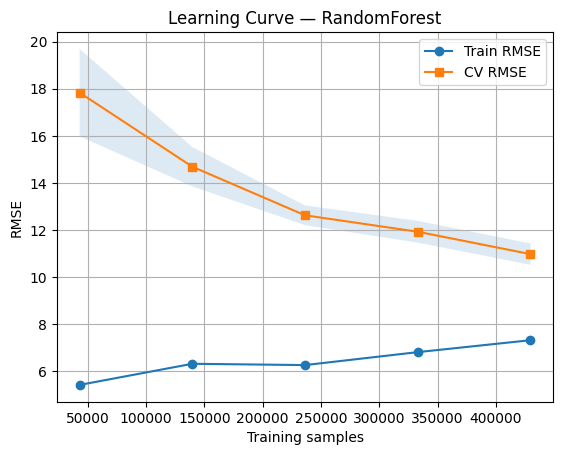

[VC] max_depth: [3, 4, 5, 8, 10, 12, None]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[INFO] CV elapsed: 3090s
[INFO] CV elapsed: 3120s
[INFO] CV elapsed: 3150s
[INFO] CV elapsed: 3180s
[INFO] CV elapsed: 3210s
[INFO] CV elapsed: 3240s


/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[INFO] CV elapsed: 3270s
[INFO] CV elapsed: 3300s
[INFO] CV elapsed: 3330s
[INFO] CV elapsed: 3360s
[INFO] CV elapsed: 3390s
[INFO] CV elapsed: 3420s
[INFO] CV elapsed: 3450s
[INFO] CV elapsed: 3480s
[INFO] CV elapsed: 3510s
[INFO] CV elapsed: 3540s
[INFO] CV elapsed: 3570s
[INFO] CV elapsed: 3600s


[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:  9.3min finished


[VC] max_depth done in 556.8s


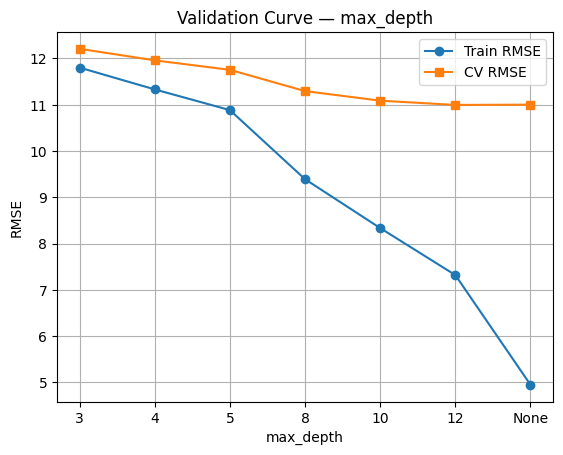

[VC] min_samples_leaf: [2, 5, 10, 20, 40]
[INFO] CV elapsed: 3630s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[INFO] CV elapsed: 3660s
[INFO] CV elapsed: 3690s
[INFO] CV elapsed: 3720s
[INFO] CV elapsed: 3750s
[INFO] CV elapsed: 3780s
[INFO] CV elapsed: 3810s
[INFO] CV elapsed: 3840s
[INFO] CV elapsed: 3870s
[INFO] CV elapsed: 3900s
[INFO] CV elapsed: 3930s
[INFO] CV elapsed: 3960s
[INFO] CV elapsed: 3990s
[INFO] CV elapsed: 4020s
[INFO] CV elapsed: 4050s
[INFO] CV elapsed: 4080s
[INFO] CV elapsed: 4110s
[INFO] CV elapsed: 4140s
[INFO] CV elapsed: 4170s


[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  9.2min finished


[VC] min_samples_leaf done in 550.3s


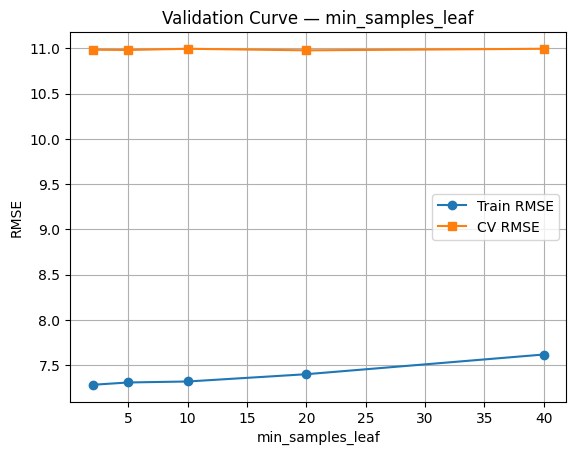

[VC] min_samples_split: [4, 10, 20, 40, 80]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[INFO] CV elapsed: 4200s
[INFO] CV elapsed: 4230s
[INFO] CV elapsed: 4260s
[INFO] CV elapsed: 4290s
[INFO] CV elapsed: 4320s
[INFO] CV elapsed: 4350s
[INFO] CV elapsed: 4380s
[INFO] CV elapsed: 4410s
[INFO] CV elapsed: 4440s
[INFO] CV elapsed: 4470s
[INFO] CV elapsed: 4500s
[INFO] CV elapsed: 4530s
[INFO] CV elapsed: 4560s
[INFO] CV elapsed: 4590s
[INFO] CV elapsed: 4620s
[INFO] CV elapsed: 4650s
[INFO] CV elapsed: 4680s
[INFO] CV elapsed: 4710s


[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  9.3min finished


[VC] min_samples_split done in 555.6s


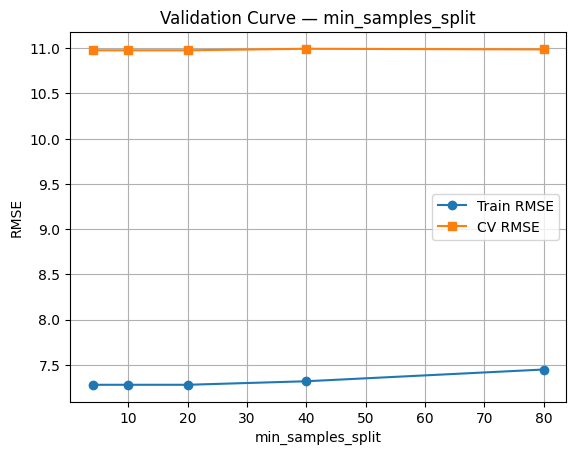

[VC] max_features: ['sqrt', 'log2', 0.5]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[INFO] CV elapsed: 4740s
[INFO] CV elapsed: 4770s
[INFO] CV elapsed: 4800s
[INFO] CV elapsed: 4830s
[INFO] CV elapsed: 4860s
[INFO] CV elapsed: 4890s
[INFO] CV elapsed: 4920s
[INFO] CV elapsed: 4950s
[INFO] CV elapsed: 4980s
[INFO] CV elapsed: 5010s
[INFO] CV elapsed: 5040s
[INFO] CV elapsed: 5070s
[INFO] CV elapsed: 5100s


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  6.4min finished


[VC] max_features done in 385.0s


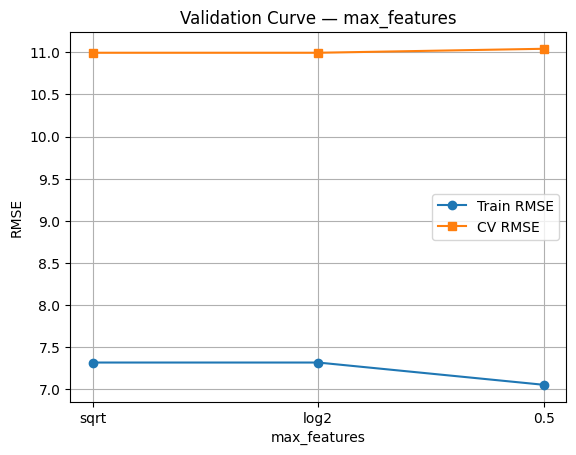

[OOB] Computing OOB curve (no CV)
[OOB] n_estimators=50 -> OOB R²=0.7664 (5.8s)
[INFO] CV elapsed: 5130s
[OOB] n_estimators=100 -> OOB R²=0.7655 (6.8s)
[OOB] n_estimators=150 -> OOB R²=0.7657 (8.7s)
[OOB] n_estimators=200 -> OOB R²=0.7658 (9.7s)
[INFO] CV elapsed: 5160s
[OOB] n_estimators=250 -> OOB R²=0.7659 (11.1s)
[OOB] n_estimators=300 -> OOB R²=0.7662 (12.4s)


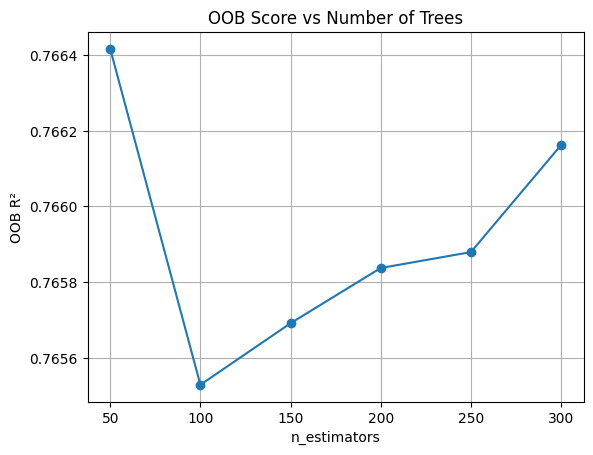

[CURVES] All done.


In [ ]:
# --- Clean override helper ---
from sklearn.ensemble import RandomForestRegressor
import numpy as np, time
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve, validation_curve

def rf_from(base_params, **overrides):
    """Return RF with base_params filtered to valid keys, then overridden."""
    valid_keys = RandomForestRegressor().get_params().keys()
    params = {k: v for k, v in base_params.items() if k in valid_keys}
    params.update(overrides)
    return RandomForestRegressor(**params)

print("[CURVES] Starting")

# Safety checks
needed = ["X_train_imp", "y_train", "groups", "gkf", "search"]
missing_vars = [v for v in needed if v not in globals()]
if missing_vars:
    raise RuntimeError(f"Missing from current session: {missing_vars}. Run your training cell first.")

base_params = search.best_estimator_.get_params()
show_keys = ["n_estimators","max_depth","min_samples_leaf","min_samples_split",
             "max_features","max_samples","ccp_alpha","oob_score","bootstrap"]
print("[INFO] Base params:", {k: base_params.get(k) for k in show_keys if k in base_params})

# ---------- Learning Curve (RMSE) ----------
print("[LC] Computing learning curve (this uses CV)")
lc_train_sizes = np.linspace(0.1, 1.0, 5)
lc_est = rf_from(base_params, n_jobs=1, oob_score=False, warm_start=False, verbose=0)
t0 = time.time()
sizes, lc_train_scores, lc_val_scores = learning_curve(
    estimator=lc_est,
    X=X_train_imp, y=y_train,
    groups=groups, cv=gkf,
    scoring="neg_root_mean_squared_error",
    train_sizes=lc_train_sizes,
    n_jobs=1, verbose=1
)
print(f"[LC] done in {time.time()-t0:.1f}s")

lc_train_rmse = -lc_train_scores
lc_val_rmse  = -lc_val_scores

plt.figure()
plt.plot(sizes, lc_train_rmse.mean(axis=1), marker="o", label="Train RMSE")
plt.plot(sizes, lc_val_rmse.mean(axis=1),   marker="s", label="CV RMSE")
plt.fill_between(sizes,
                 lc_val_rmse.mean(axis=1)-lc_val_rmse.std(axis=1),
                 lc_val_rmse.mean(axis=1)+lc_val_rmse.std(axis=1),
                 alpha=0.15)
plt.xlabel("Training samples"); plt.ylabel("RMSE"); plt.title("Learning Curve — RandomForest")
plt.legend(); plt.grid(True); plt.show()

# ---------- Validation Curves (RMSE vs hyperparameter) ----------
param_ranges = {
    "max_depth":         [3, 4, 5, 8, 10, 12, None],
    "min_samples_leaf":  [2, 5, 10, 20, 40],
    "min_samples_split": [4, 10, 20, 40, 80],
    "max_features":      ["sqrt", "log2", 0.5],
}

def plot_validation_curve(param_name, param_range):
    print(f"[VC] {param_name}: {param_range}")
    est = rf_from(base_params, n_jobs=1, oob_score=False, warm_start=False, verbose=0)
    t0 = time.time()
    tr_scores, va_scores = validation_curve(
        estimator=est,
        X=X_train_imp, y=y_train,
        param_name=param_name, param_range=param_range,
        groups=groups, cv=gkf,
        scoring="neg_root_mean_squared_error",
        n_jobs=1, verbose=1
    )
    print(f"[VC] {param_name} done in {time.time()-t0:.1f}s")
    tr_rmse, va_rmse = -tr_scores, -va_scores

    x_vals = [("None" if v is None else v) for v in param_range]
    plt.figure()
    plt.plot(x_vals, tr_rmse.mean(axis=1), marker="o", label="Train RMSE")
    plt.plot(x_vals, va_rmse.mean(axis=1), marker="s", label="CV RMSE")
    plt.xlabel(param_name); plt.ylabel("RMSE"); plt.title(f"Validation Curve — {param_name}")
    plt.legend(); plt.grid(True); plt.show()

for p, rng in param_ranges.items():
    plot_validation_curve(p, rng)

# ---------- OOB Curve (OOB R² vs number of trees) ----------
print("[OOB] Computing OOB curve (no CV)")
oob_list = [50, 100, 150, 200, 250, 300]
oob_scores = []
oob_est = rf_from(base_params, oob_score=True, bootstrap=True, warm_start=True,
                  n_jobs=-1, verbose=0)
for n in oob_list:
    t0 = time.time()
    oob_est.set_params(n_estimators=n)
    oob_est.fit(X_train_imp, y_train)
    oob_scores.append(oob_est.oob_score_)
    print(f"[OOB] n_estimators={n} -> OOB R²={oob_est.oob_score_:.4f} ({time.time()-t0:.1f}s)")

plt.figure()
plt.plot(oob_list, oob_scores, marker="o")
plt.xlabel("n_estimators"); plt.ylabel("OOB R²"); plt.title("OOB Score vs Number of Trees")
plt.grid(True); plt.show()

print("[CURVES] All done.")


### Let's create a randomized sample size and try to test the hyperparameters


In [ ]:
# ==== SIMPLE SAMPLER (run this first) ====
import numpy as np
import pandas as pd

# ---- USER KNOBS (edit these) ----
SEED = 42
TARGET_COL = "yield"
FIELD_COL  = "field"
YEAR_COL   = "year"

SAMPLE_SIZE_TARGET = 25_000   # typical: 50k (try 80k–100k if you have resources)
MIN_PER_GROUP      = 65      # ensure coverage per field×year
MAX_PER_GROUP      = 1000     # avoid domination by big groups
BASE_FRAC          = 0.10     # start by taking ~10% from each group
# --------------------------------

rng = np.random.default_rng(SEED)
df = df_soybeans_scaled.copy()

# Build group key
df["field_year"] = df[FIELD_COL].astype(str) + "_" + df[YEAR_COL].astype(str)

# Group sizes and initial allocation
gsize = df.groupby("field_year").size()
alloc = np.ceil(gsize * BASE_FRAC).astype(int)
alloc = alloc.clip(lower=MIN_PER_GROUP, upper=MAX_PER_GROUP)
alloc = np.minimum(alloc, gsize)  # cannot exceed what's available

# Simple adjuster to match SAMPLE_SIZE_TARGET (no fancy math; easy to read)
def adjust_allocation_simple(alloc, target, gsize, min_k, max_k):
    alloc = alloc.copy()
    total = int(alloc.sum())

    # Scale DOWN by peeling 1 at a time from the largest groups (above min_k)
    while total > target:
        # candidates that can give 1 back
        can_give = alloc[alloc > min_k]
        if can_give.empty:
            break
        idx = can_give.sort_values(ascending=False).index[0]
        alloc.loc[idx] -= 1
        total -= 1

    # Scale UP by adding 1 at a time to groups with headroom
    while total < target:
        headroom = (np.minimum(max_k, gsize) - alloc)
        can_take = headroom[headroom > 0]
        if can_take.empty:
            break
        # give to the group currently smallest (for balance)
        idx = (alloc.loc[can_take.index]).sort_values(ascending=True).index[0]
        alloc.loc[idx] += 1
        total += 1

    return alloc

alloc = adjust_allocation_simple(
    alloc=alloc,
    target=SAMPLE_SIZE_TARGET,
    gsize=gsize,
    min_k=MIN_PER_GROUP,
    max_k=MAX_PER_GROUP
)

# Draw samples per group (reproducible)
sampled_parts = []
for gy, k in alloc.items():
    if k <= 0:
        continue
    gdf = df[df["field_year"] == gy]
    sampled_parts.append(gdf.sample(n=int(k), random_state=SEED, replace=False))

sampled_tuning_set = pd.concat(sampled_parts, ignore_index=True)

# Quick report
total_groups = df["field_year"].nunique()
covered_groups = sampled_tuning_set["field_year"].nunique()
per_group_counts = sampled_tuning_set.groupby("field_year").size()

print("=== Sampling Summary ===")
print(f"Requested size: {SAMPLE_SIZE_TARGET:,}")
print(f"Actual size:    {len(sampled_tuning_set):,}")
print(f"Groups covered: {covered_groups}/{total_groups} "
      f"({covered_groups/total_groups*100:.1f}%)")
print(f"Median per-group sample: {int(per_group_counts.median())}")

# Keep only what we need going forward (optional but tidy)
# sampled_tuning_set now holds your training sample for cell 2.


=== Sampling Summary ===
Requested size: 25,000
Actual size:    25,050
Groups covered: 386/386 (100.0%)
Median per-group sample: 65


In [35]:
# ==== VERBOSE TUNING + CURVES (fewer extra refits) ====
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GroupKFold, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_absolute_error
from scipy.stats import randint, uniform, reciprocal
import time

print("[SETUP] Starting Cell 2…")

# ---------------- USER KNOBS ----------------
SEED = 42
TARGET_COL = "yield"
NON_FEATURES = {"yield", "field", "year", "field_year"}

USE_TIME_SERIES_CV = False  # True = year-forward CV; False = GroupKFold
N_SPLITS = 5
N_ITER   = 40
N_JOBS   = 1
SCORING  = "r2"            # or "neg_mean_absolute_error"

LC_FRACTIONS = [0.1, 0.25, 0.5, 0.75, 1.0]  # learning curve (still needs refits)

# For “validation curves”, we'll derive them from cv_results_ (no extra fits)
VC_PARAMS_TO_SUMMARIZE = ["n_estimators","max_depth","min_samples_leaf",
                          "max_features","min_samples_split"]

# OOB curve via warm_start (single growing model)
OOB_N_ESTIMATORS = [50, 100, 200, 400, 800, 1200, 1600]
# ------------------------------------------------------

rng = np.random.default_rng(SEED)

# --- Features / data
print("[DATA] Inferring feature columns…")
cand_cols = [c for c in sampled_tuning_set.columns if c not in NON_FEATURES]
FEATURES = [c for c in cand_cols if np.issubdtype(sampled_tuning_set[c].dtype, np.number)]
print(f"[DATA] Feature count: {len(FEATURES)}")
print(f"[DATA] Rows in sampled_tuning_set: {len(sampled_tuning_set):,}")

X = sampled_tuning_set[FEATURES].values
y = sampled_tuning_set[TARGET_COL].values
groups = sampled_tuning_set["field_year"].values
years = sampled_tuning_set["year"].values.astype(int)

# --- CV splitter
if USE_TIME_SERIES_CV:
    years_unique = np.sort(np.unique(years))
    folds = []
    for i in range(1, len(years_unique)):
        train_years = set(years_unique[:i])
        val_year    = years_unique[i]
        tr_idx = np.where(np.isin(years, list(train_years)))[0]
        va_idx = np.where(years == val_year)[0]
        if len(tr_idx) and len(va_idx):
            folds.append((tr_idx, va_idx))
    if len(folds) < 2:
        print("[CV] WARNING: <2 folds; scores may be unstable.")
    cv = folds
    print(f"[CV] Using Time-Series CV with {len(folds)} folds over years: {years_unique.tolist()}")
else:
    print("[CV] Using GroupKFold…")
    cv = GroupKFold(n_splits=N_SPLITS).split(X, y, groups=groups)

# --- Strong, clean search space
print("[SEARCH] Defining parameter distributions…")
param_distributions = {
    "n_estimators":          randint(100, 900),         # 200..1600
    "max_depth":             [2,3,5,7,8, 12, 16, 20],
    "min_samples_leaf":      randint(2, 31),             # 1..50
    "min_samples_split":     randint(4, 101),            # 2..200
    "max_features":          ["sqrt", "log2", 0.3, 0.5, 0.7, 0.9],
    "max_samples":           uniform(0.5, 0.5),          # [0.5,1.0)
    # "min_impurity_decrease": reciprocal(1e-9, 1e-4),     # log-uniform-ish
    # "ccp_alpha":             reciprocal(1e-7, 1e-3),     # log-uniform-ish
     "min_impurity_decrease": [0.0],
    "ccp_alpha":               [0.0]
}

base_est = RandomForestRegressor(random_state=SEED, n_jobs=1, bootstrap=True)

# --- RandomizedSearchCV
print("[SEARCH] Starting RandomizedSearchCV…")
t0 = time.time()
search = RandomizedSearchCV(
    estimator=base_est,
    param_distributions=param_distributions,
    n_iter=N_ITER,
    cv=cv,
    scoring=SCORING,
    n_jobs=1,
    verbose=3,
    random_state=SEED,
    refit=True,
    return_train_score=True
)
search.fit(X, y)
t1 = time.time()
print(f"[SEARCH] Finished in {t1 - t0:.1f}s")

print("\n=== Best Params ===")
print(search.best_params_)
print(f"Best CV ({SCORING}) score: {search.best_score_:.4f}")

# --- Full CV history (we'll reuse this to build “validation curves”)
print("[SEARCH] Collecting cv_results_…")
search_results_df = pd.DataFrame(search.cv_results_)
print(f"[SEARCH] cv_results_: {search_results_df.shape[0]} candidates")

# --- Diagnostics on the sampled set
print("\n[DIAG] Evaluating best estimator on sampled set (not generalization)…")
best_model = search.best_estimator_
y_hat = best_model.predict(X)
print(f"[DIAG] In-sample R^2:  {r2_score(y, y_hat):.4f}")
print(f"[DIAG] In-sample MAE:  {mean_absolute_error(y, y_hat):.4f}")

# =====================================================================
#                 LEARNING CURVE (requires multiple fits)
# =====================================================================
print("\n[LC] Computing learning curves…")
lc_rows = []
if USE_TIME_SERIES_CV:
    years_unique = np.sort(np.unique(years))
    for frac in LC_FRACTIONS:
        max_i = max(1, int(len(years_unique) * frac)) - 1
        max_i = min(max_i, len(years_unique) - 2)
        cutoff_year = years_unique[max_i]
        next_year   = years_unique[max_i + 1]
        tr_idx = np.where(years <= cutoff_year)[0]
        va_idx = np.where(years == next_year)[0]
        if len(tr_idx)==0 or len(va_idx)==0:
            print(f"   [LC][ts] skip frac={frac:.2f}: insufficient data")
            continue
        model = RandomForestRegressor(**search.best_params_, random_state=SEED, n_jobs=1)
        model.fit(X[tr_idx], y[tr_idx])
        y_tr  = model.predict(X[tr_idx]); y_va = model.predict(X[va_idx])
        row = {
            "frac": frac, "train_size": len(tr_idx),
            "r2_train": r2_score(y[tr_idx], y_tr), "r2_val": r2_score(y[va_idx], y_va),
            "mae_train": mean_absolute_error(y[tr_idx], y_tr), "mae_val": mean_absolute_error(y[va_idx], y_va),
            "train_years_max": int(cutoff_year), "val_year": int(next_year),
        }
        lc_rows.append(row)
        print(f"   [LC][ts] up_to={cutoff_year} → val={next_year} | R2(tr)={row['r2_train']:.3f} R2(val)={row['r2_val']:.3f}")
else:
    gkf = GroupKFold(n_splits=N_SPLITS)
    for frac in LC_FRACTIONS:
        print(f"[LC][gkf] frac={frac:.2f}")
        for fold_id, (tr_idx, va_idx) in enumerate(gkf.split(X, y, groups=groups), start=1):
            n_take = max(1, int(len(tr_idx) * frac))
            take_idx = rng.choice(tr_idx, size=n_take, replace=False)
            model = RandomForestRegressor(**search.best_params_, random_state=SEED, n_jobs=1)
            model.fit(X[take_idx], y[take_idx])
            y_tr = model.predict(X[take_idx]); y_va = model.predict(X[va_idx])
            row = {
                "frac": frac, "fold": fold_id, "train_size": n_take,
                "r2_train": r2_score(y[take_idx], y_tr), "r2_val": r2_score(y[va_idx], y_va),
                "mae_train": mean_absolute_error(y[take_idx], y_tr), "mae_val": mean_absolute_error(y[va_idx], y_va)
            }
            lc_rows.append(row)
            print(f"   [LC][gkf][fold {fold_id}] n={n_take} | R2(tr)={row['r2_train']:.3f} R2(val)={row['r2_val']:.3f}")
lc_df = pd.DataFrame(lc_rows)
print("[LC] Done. Rows:", len(lc_df))

# =====================================================================
#         “VALIDATION CURVES” from cv_results_ (no extra refits)
# =====================================================================
print("\n[VC] Summarizing validation curves from RandomizedSearchCV history…")
vc_results = {}
# Keep only the columns we need
cols = ["mean_test_score","std_test_score"] + [f"param_{p}" for p in VC_PARAMS_TO_SUMMARIZE if f"param_{p}" in search_results_df.columns]
tmp = search_results_df[cols].copy()

for p in VC_PARAMS_TO_SUMMARIZE:
    col = f"param_{p}"
    if col not in tmp.columns:
        print(f"   [VC] Skipping {p}: not present in search grid.")
        continue
    # Convert to numeric where possible (e.g., None stays as object)
    vc = tmp[[col,"mean_test_score","std_test_score"]].copy()
    # vc = vc.sort_values("r2_val_mean", ascending=False)
    vc_results[p] = vc
    print(f"   [VC] {p} candidates: {len(vc)}")
    print(vc.head(10))

# =====================================================================
#                   OOB CURVE via warm_start (one model)
# =====================================================================
print("\n[OOB] Computing OOB curve with a single growing model…")
oob_rows = []
ws_model = RandomForestRegressor(
    **search.best_params_,
    warm_start=True,        # grow same model
    oob_score=True,
    bootstrap=True,
    n_jobs=1,
    random_state=SEED
)
start = OOB_N_ESTIMATORS[0]
ws_model.set_params(n_estimators=start)
print(f"[OOB] Fitting initial {start} trees…")
ws_model.fit(X, y)
oob_rows.append({"n_estimators": start, "oob_score": float(ws_model.oob_score_)})

for n_est in OOB_N_ESTIMATORS[1:]:
    print(f"[OOB] Growing to {n_est} trees…")
    ws_model.set_params(n_estimators=n_est)
    ws_model.fit(X, y)  # adds trees due to warm_start=True
    oob_rows.append({"n_estimators": n_est, "oob_score": float(ws_model.oob_score_)})
    print(f"   [OOB] n={n_est} -> OOB R2={ws_model.oob_score_:.4f}")

oob_df = pd.DataFrame(oob_rows)
print("[OOB] Done.")
print(oob_df)

# =====================================================================
#                      SUMMARY OF ARTIFACTS
# =====================================================================
print("\n[SUMMARY] Artifacts ready for plotting/inspection:")
print(" - search_results_df : full RandomizedSearchCV history")
print(" - lc_df             : learning-curve points")
print(" - vc_results        : dict of DataFrames derived from cv_results_ (no extra fits)")
print(" - oob_df            : OOB score vs n_estimators (warm_start single model)")

# Optional saves
# search_results_df.to_csv("cv_results_randomized_search.csv", index=False)
# lc_df.to_csv("learning_curve_points.csv", index=False)
# for k, dfk in vc_results.items(): dfk.to_csv(f"validation_curve_{k}.csv", index=False)
# oob_df.to_csv("oob_curve.csv", index=False)

print("[DONE] Cell 2 complete.")



   [VC] n_estimators candidates: 40
   param_n_estimators  mean_test_score  std_test_score
0                 800         0.606552        0.058103
1                 187         0.566158        0.057939
2                 408         0.589115        0.056298
3                 376         0.447728        0.064950
4                 660         0.392818        0.048958
5                 882         0.529634        0.063469
6                 343         0.591225        0.052707
7                 120         0.595135        0.059706
8                 341         0.355850        0.027152
9                 191         0.442416        0.046916
   [VC] max_depth candidates: 40
   param_max_depth  mean_test_score  std_test_score
0               16         0.606552        0.058103
1                8         0.566158        0.057939
2                8         0.589115        0.056298
3                3         0.447728        0.064950
4                2         0.392818        0.048958
5             